In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
import io
import pickle
import json

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F

from uNetModel import *

In [2]:
# For this cell used same code from PyTorch notebook in assignment 2 of Stanford's CS231n Spring 2018 offering
preprocessData = False # To preprocess data set this to True
USE_GPU = True
dtype = torch.float32
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    dtype = torch.float32

# Constant to control how frequently we print train loss
print_every = 1

print('using device:', device)

using device: cuda


In [3]:
# Next two cells, code belongs to [1]. Minor changes made to accomodate to our use 
# (Using PyTorch instead of Keras/tensorflow)
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
PATH = './stage1_train/'
epsilon = 1e-12 #For numerical stability

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 1
random.seed = seed
np.random.seed = seed

In [4]:
if preprocessData:
    # Get IDs
    try:
        ids = next(os.walk(PATH))[1]
        #print(ids)
    except StopIteration:
        pass # Some error handling here

    #print("HERE")

    # Get and resize images and masks
    X = np.zeros((len(ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype= np.float32)
    Y = np.zeros((len(ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype= np.float32)
    print('Getting and resizing train images and masks ... ')
    sys.stdout.flush()
    for n, id_ in tqdm(enumerate(ids), total=len(ids)):
        path = PATH + id_
        img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X[n] = img
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)
        for mask_file in next(os.walk(path + '/masks/'))[2]:
            mask_ = imread(path + '/masks/' + mask_file)
            mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',
                                          preserve_range=True), axis=-1)
            mask = np.maximum(mask, mask_)
        Y[n] = mask
    print('Done!')

In [5]:
X_train = None
Y_train = None
X_val = None
Y_val = None
X_test = None
Y_test = None
if preprocessData: # If we preprocessed data, randomly shuffle data into 3 sets
    # Splitting data into train/val/test set in a 60/20/20 split
    shuffled_indices = np.random.permutation(len(X))

    train_indices = shuffled_indices[0:int(.6*(len(X)))]
    val_indices = shuffled_indices[int(.6*(len(X))): int(.8*(len(X)))]
    test_indices = shuffled_indices[int(.8*(len(X))):]

    X_train = X[train_indices]
    Y_train = Y[train_indices]
    Y_train[Y_train.nonzero()] = 1
    X_val = X[val_indices]
    Y_val = Y[val_indices]
    Y_val[Y_val.nonzero()] = 1
    X_test = X[test_indices]
    Y_test = Y[test_indices]
    Y_test[Y_test.nonzero()] = 1

    # Let us visualize what inputs outputs look like
    randIndex = random.randint(0, len(X_train))
    imshow(np.uint8(X_train[randIndex]))
    plt.show()
    imshow(np.squeeze(np.uint8(Y_train[randIndex])))
    plt.show()

    # X_train /= 256
    # X_val /= 256
    # X_test /= 256

    X_train = np.transpose(X_train, (0,3,1,2))
    Y_train = np.transpose(Y_train, (0,3,1,2))
    X_val = np.transpose(X_val, (0,3,1,2))
    Y_val = np.transpose(Y_val, (0,3,1,2))
    X_test = np.transpose(X_test, (0,3,1,2))
    Y_test = np.transpose(Y_test, (0,3,1,2))

    json_data = {'X_train':X_train.tolist(), 'Y_train':Y_train.tolist(), 'X_val':X_val.tolist(), 'Y_val':Y_val.tolist(),
                                        'X_test':X_test.tolist(), 'Y_test':Y_test.tolist()}
    with open('processedData.json', 'w') as outfile:
        json.dump(json_data, outfile)
else: # else load from json file
    with open('processedData.json') as f:
        data = json.load(f)
    X_train = np.array(data['X_train'])
    Y_train = np.array(data['Y_train'])
    X_val = np.array(data['X_val'])
    Y_val = np.array(data['Y_val'])
    X_test = np.array(data['X_test'])
    Y_test = np.array(data['Y_test'])

print('Shape of X_train = ', X_train.shape)
print('Shape of Y_train = ', Y_train.shape)
print('Shape of X_val = ', X_val.shape)
print('Shape of Y_val = ', Y_val.shape)
print('Shape of X_test = ', X_test.shape)
print('Shape of Y_test = ', Y_test.shape)

Shape of X_train =  (402, 3, 128, 128)
Shape of Y_train =  (402, 1, 128, 128)
Shape of X_val =  (134, 3, 128, 128)
Shape of Y_val =  (134, 1, 128, 128)
Shape of X_test =  (134, 3, 128, 128)
Shape of Y_test =  (134, 1, 128, 128)


In [6]:
def showVisualComparisons(y, pred):
    y_reshaped = np.transpose(y, (1,2,0))
    pred_reshaped = np.transpose(pred, (1,2,0))
    imshow(np.squeeze(np.uint8(y_reshaped)))
    plt.show()
    imshow(np.squeeze(np.uint8(pred_reshaped)))
    plt.show()

In [7]:
def calc_iou(preds, y):
    preds = preds.view(preds.shape[0], -1)
    y = y.view(y.shape[0], -1)
    intersection = (y*preds.type(torch.float)).sum()
    union = y.sum() + (preds.type(torch.float)).sum() - intersection
    return (intersection/(union))

In [8]:
def calculatePerformance(X_perf, Y_perf, model, mini_batch_size =  64,visual = False):
    model.eval() #set model to evaluation mode
    mean_iou = 0
    num_batches = int(len(X_perf)/mini_batch_size)
    num_remaining = len(X_perf) - num_batches *mini_batch_size
    with torch.no_grad():
        for i in range(num_batches):
            x = torch.from_numpy(X_perf[i*mini_batch_size:(i+1)*mini_batch_size, :, :, :])
            y = torch.from_numpy(Y_perf[i*mini_batch_size:(i+1)*mini_batch_size, :, :, :])
            x = x.to(device = device, dtype = dtype)
            y = y.to(device = device, dtype = dtype)
            preds = model(x)
            preds = (preds > 0.5)
            mean_iou += float(mini_batch_size)*calc_iou(preds, y)
        x = torch.from_numpy(X_perf[num_batches*mini_batch_size:, :, :, :])
        y = torch.from_numpy(Y_perf[num_batches*mini_batch_size:, :, :, :])
        x = x.to(device = device, dtype = dtype)
        y = y.to(device = device, dtype = dtype)
        preds = model(x)
        preds = (preds > 0.5)
        if visual:
            ix = np.random.randint((num_batches*mini_batch_size), len(X_perf))
            showVisualComparisons(Y_perf[ix, :, :, :], preds[(ix - (num_batches*mini_batch_size)), :, :, :].cpu().numpy())
        mean_iou += float(num_remaining)*calc_iou(preds, y)
    return (mean_iou/(float(len(X_perf))))

In [9]:
def trainModel(model, x_train, y_train, optimizer, epochs = 1, mini_batch_size = 64, noVal = False):
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    T = 0
    num_batches = int(len(x_train)/mini_batch_size)
    num_remaining = len(x_train) - num_batches *mini_batch_size
    loss_history = []
    for e in range(epochs):
        for t in range(num_batches):
            rand_indices = np.random.choice(len(x_train), mini_batch_size)
            x = torch.from_numpy(x_train[rand_indices, :, :, :])
            y = torch.from_numpy(y_train[rand_indices, :, :, :])
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)

            preds = model(x)
            loss = F.binary_cross_entropy(preds, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if T % print_every == 0:
                currLoss = loss.item()
                loss_history.append(currLoss)
                print('Epoch %d, Iteration %d, loss = %.4f' % (e, t, currLoss))
            if (num_remaining <= 0 and t == (num_batches -1)):
                iou = calculatePerformance(x_train, y_train, model)
                print('Train Mean IOU at epoch %d is %.4f' % (e, iou))
                if (noVal == False):
                    iou = calculatePerformance(X_val, Y_val, model)
                    print('Val Mean IOU at epoch %d is %.4f' % (e, iou))
            T +=1
        if num_remaining > 0:
            rand_indices = np.random.choice(len(x_train), num_remaining)
            x = torch.from_numpy(x_train[rand_indices, :, :, :])
            y = torch.from_numpy(y_train[rand_indices, :, :, :])
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)

            preds = model(x)
            loss = F.binary_cross_entropy(preds, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
            if T % print_every == 0:
                currLoss = loss.item()
                loss_history.append(currLoss)
                print('Epoch %d, Iteration %d, loss = %.4f' % (e, num_batches, currLoss))
            iou = calculatePerformance(x_train, y_train, model)
            print('Train Mean IOU at epoch %d is %.4f' % (e, iou))
            if (noVal == False):
                iou = calculatePerformance(X_val, Y_val, model)
                print('Val Mean IOU at epoch %d is %.4f' % (e, iou))
            T +=1
    return calculatePerformance(x_train, y_train, model),loss_history

In [20]:
# Overfitting data first
bestPerf = -1
lossHistory = None
lossHistories = {}
print_every = 1
bestModel = None
bestLoss = 10000
lrUsed = 0
x_train = X_train[0:50, :, :, :]
y_train = Y_train[0:50, :, :, :]
lrs = []
for i in range(4):
    lrs.append(5*np.random.rand()*1e-3)
# lrs = [1e-7,1e-6,1e-5,1e-4,1e-3]
lrs.append(.002147418314081924) # Best result from last random searches
for lr in lrs:
    print('Trying out learning rate of ', lr)
    model = UNet()
    optimizer = optim.Adam(model.parameters(), lr = lr)
    modelPerf = trainModel(model, x_train, y_train, optimizer, epochs = 25, noVal = True)
    lossHistories[str(lr)] = modelPerf[1]
    if modelPerf[1][len(modelPerf[1])-1] < bestLoss:
        bestLoss = modelPerf[1][len(modelPerf[1])-1]
        bestPerf = modelPerf[0]
        lossHistory = modelPerf[1]
        bestModel = model
        lrUsed = lr

Trying out learning rate of  0.004936514580603218
Epoch 0, Iteration 0, loss = 2.5426
Train Mean IOU at epoch 0 is 0.5161
Epoch 1, Iteration 0, loss = 2.2509
Train Mean IOU at epoch 1 is 0.2967
Epoch 2, Iteration 0, loss = 0.9161
Train Mean IOU at epoch 2 is 0.1107
Epoch 3, Iteration 0, loss = 0.7225
Train Mean IOU at epoch 3 is 0.2869
Epoch 4, Iteration 0, loss = 0.8071
Train Mean IOU at epoch 4 is 0.0558
Epoch 5, Iteration 0, loss = 1.0860
Train Mean IOU at epoch 5 is 0.0791
Epoch 6, Iteration 0, loss = 0.9648
Train Mean IOU at epoch 6 is 0.1262
Epoch 7, Iteration 0, loss = 0.6140
Train Mean IOU at epoch 7 is 0.2060
Epoch 8, Iteration 0, loss = 0.5907
Train Mean IOU at epoch 8 is 0.2391
Epoch 9, Iteration 0, loss = 0.5529
Train Mean IOU at epoch 9 is 0.2121
Epoch 10, Iteration 0, loss = 0.5379
Train Mean IOU at epoch 10 is 0.1620
Epoch 11, Iteration 0, loss = 0.5269
Train Mean IOU at epoch 11 is 0.1341
Epoch 12, Iteration 0, loss = 0.5363
Train Mean IOU at epoch 12 is 0.1284
Epoch 13

Best learning rate used to train was  0.004936514580603218


/home/shared/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


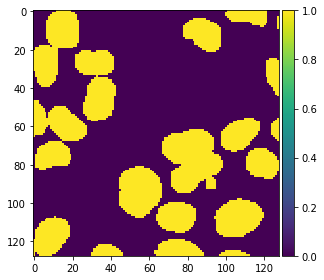

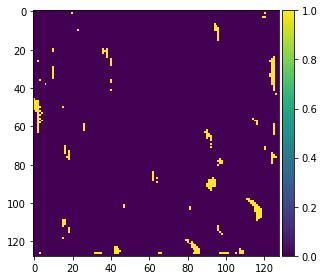

Best train IOU =  tensor(0.1937, device='cuda:0')


/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  This is separate from the ipykernel package so we can avoid doing imports until


In [21]:
# Let us visualize how different our predicted masks are
print('Best learning rate used to train was ', lrUsed)
print('Best train IOU = ', (calculatePerformance(x_train, y_train, bestModel, visual = True))[0])

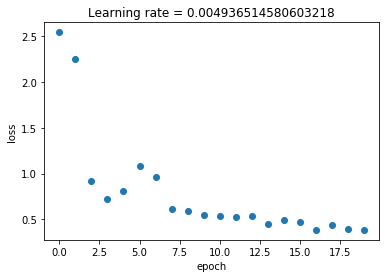

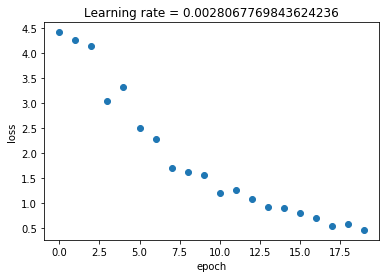

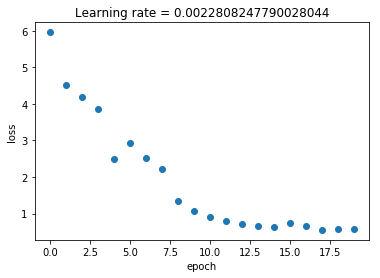

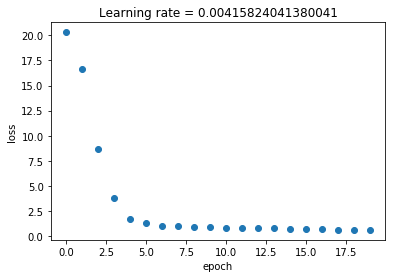

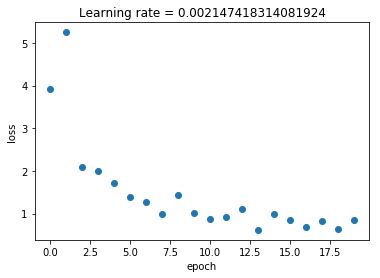

Lowest loss =  0.3890487551689148


In [22]:
# Let us take a look at the loss history to verify training
for lr, lossHist in lossHistories.items():
    plt.plot((np.arange(len(lossHist))),lossHist, 'o')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Learning rate = '+ lr)
    plt.show()
print('Lowest loss = ', str(lossHistory[len(lossHistory)-1]))

In [37]:
model = UNet()
optimizer = optim.Adam(model.parameters(), lr = 0.002147418314081924)
modelPerf, lossHistory = trainModel(model, X_train, Y_train, optimizer, epochs = 80, noVal = True)

Epoch 0, Iteration 0, loss = 5.9345
Epoch 0, Iteration 1, loss = 2.7400
Epoch 0, Iteration 2, loss = 1.9338
Epoch 0, Iteration 3, loss = 2.0054
Epoch 0, Iteration 4, loss = 1.4808
Epoch 0, Iteration 5, loss = 1.7320
Epoch 0, Iteration 6, loss = 1.5155
Train Mean IOU at epoch 0 is 0.2279
Epoch 1, Iteration 0, loss = 1.3680
Epoch 1, Iteration 1, loss = 1.0442
Epoch 1, Iteration 2, loss = 1.1102
Epoch 1, Iteration 3, loss = 1.1592
Epoch 1, Iteration 4, loss = 1.0679
Epoch 1, Iteration 5, loss = 0.9601
Epoch 1, Iteration 6, loss = 0.8921
Train Mean IOU at epoch 1 is 0.2909
Epoch 2, Iteration 0, loss = 1.0628
Epoch 2, Iteration 1, loss = 0.8698
Epoch 2, Iteration 2, loss = 0.8204
Epoch 2, Iteration 3, loss = 0.8519
Epoch 2, Iteration 4, loss = 0.7387
Epoch 2, Iteration 5, loss = 0.7377
Epoch 2, Iteration 6, loss = 0.6453
Train Mean IOU at epoch 2 is 0.2697
Epoch 3, Iteration 0, loss = 0.6798
Epoch 3, Iteration 1, loss = 0.5474
Epoch 3, Iteration 2, loss = 0.8282
Epoch 3, Iteration 3, loss =

Epoch 28, Iteration 0, loss = 0.1545
Epoch 28, Iteration 1, loss = 0.1299
Epoch 28, Iteration 2, loss = 0.1286
Epoch 28, Iteration 3, loss = 0.2777
Epoch 28, Iteration 4, loss = 0.1713
Epoch 28, Iteration 5, loss = 0.1308
Epoch 28, Iteration 6, loss = 0.1785
Train Mean IOU at epoch 28 is 0.2645
Epoch 29, Iteration 0, loss = 0.1692
Epoch 29, Iteration 1, loss = 0.1494
Epoch 29, Iteration 2, loss = 0.1732
Epoch 29, Iteration 3, loss = 0.1234
Epoch 29, Iteration 4, loss = 0.1765
Epoch 29, Iteration 5, loss = 0.1671
Epoch 29, Iteration 6, loss = 0.1010
Train Mean IOU at epoch 29 is 0.2735
Epoch 30, Iteration 0, loss = 0.1320
Epoch 30, Iteration 1, loss = 0.1304
Epoch 30, Iteration 2, loss = 0.1685
Epoch 30, Iteration 3, loss = 0.1216
Epoch 30, Iteration 4, loss = 0.1814
Epoch 30, Iteration 5, loss = 0.1484
Epoch 30, Iteration 6, loss = 0.1202
Train Mean IOU at epoch 30 is 0.2953
Epoch 31, Iteration 0, loss = 0.1310
Epoch 31, Iteration 1, loss = 0.1617
Epoch 31, Iteration 2, loss = 0.2156
E

Train Mean IOU at epoch 55 is 0.2985
Epoch 56, Iteration 0, loss = 0.0989
Epoch 56, Iteration 1, loss = 0.0989
Epoch 56, Iteration 2, loss = 0.0829
Epoch 56, Iteration 3, loss = 0.0879
Epoch 56, Iteration 4, loss = 0.1305
Epoch 56, Iteration 5, loss = 0.0839
Epoch 56, Iteration 6, loss = 0.0901
Train Mean IOU at epoch 56 is 0.2929
Epoch 57, Iteration 0, loss = 0.0762
Epoch 57, Iteration 1, loss = 0.0886
Epoch 57, Iteration 2, loss = 0.1308
Epoch 57, Iteration 3, loss = 0.0919
Epoch 57, Iteration 4, loss = 0.0949
Epoch 57, Iteration 5, loss = 0.0811
Epoch 57, Iteration 6, loss = 0.0879
Train Mean IOU at epoch 57 is 0.2849
Epoch 58, Iteration 0, loss = 0.0840
Epoch 58, Iteration 1, loss = 0.0855
Epoch 58, Iteration 2, loss = 0.1305
Epoch 58, Iteration 3, loss = 0.0726
Epoch 58, Iteration 4, loss = 0.0619
Epoch 58, Iteration 5, loss = 0.0730
Epoch 58, Iteration 6, loss = 0.0923
Train Mean IOU at epoch 58 is 0.2799
Epoch 59, Iteration 0, loss = 0.0728
Epoch 59, Iteration 1, loss = 0.0881
E

/home/shared/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


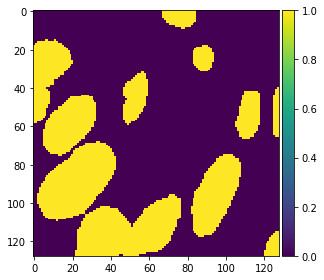

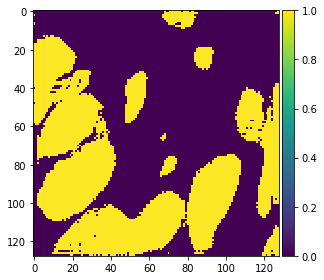

Train IOU =  0.8173409700393677
Val IOU =  0.7752678394317627


/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  
/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
model = torch.load('baselineModel')
print('Train IOU = ', (calculatePerformance(X_train, Y_train, model, visual = True))[0].item())
print('Val IOU = ', (calculatePerformance(X_val, Y_val, model, visual = False))[0].item())

In [14]:
# Sample of how to save/load model
torch.save(model, 'baselineModel')
newModel = torch.load('baselineModel')

# References
[1] Amdal-Saevik, K. (2018). Keras U-Net starter - LB 0.277. 
https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277?scriptVersionId=2164855/code

[2] Ho, D. J., Fu, C., Salama, P., Dunn, K. W., and Delp, E. J. (2017, July). Nuclei Segmentation of Fluorescence Microscopy Images Using Three Dimensional Convolutional Neural Networks. In Computer Vision and Pattern Recognition Workshops (CVPRW), 2017 IEEE Conference on (pp. 834-842). IEEE.

[3] Kakade, A., and Dumbali, J. (2018, February). Identification of nerve in ultrasound images using U-net architecture. In 2018 International Conference on Communication information and Computing Technology (ICCICT) (pp. 1-6). IEEE.

[4] Li, X., Chen, H., Qi, X., Dou, Q., Fu, C. W., and Heng, P. A. (2017). H-DenseUNet: Hybrid densely connected UNet for liver and liver tumor segmentation from CT volumes. arXiv preprint arXiv:1709.07330.

[5] Ronneberger, O., Fischer, P., and Brox, T. 
(2015, October). U-net: Convolutional networks for biomedical image segmentation. In International Conference on Medical image computing and computer-assisted intervention (pp. 234-241). Springer, Cham.

[6] Pearce, C. Convolutional (2017). Neural Networks and the Analysis of Cancer Imagery.